# Beat Analysis

Here I'm analysing the data generated from the rust code, to train on the model.

In [71]:
import os.path
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt

In [202]:
DATA_DIR = "../mixxx_data/data"

In [215]:
def load_data(filename):
    file = os.path.join(filename)
    with open(file, 'rb') as f:
        data = dict(pickle.load(f))
    return data

In [206]:
data = load_data(ps.path.join(DATA_DIR, "0.pickle"))
target = np.array(data['target'])[:,None]
hist = np.array(data['hist'])
joined_data = np.hstack((hist, target))
joined_data = np.clip(joined_data, 0, 1)

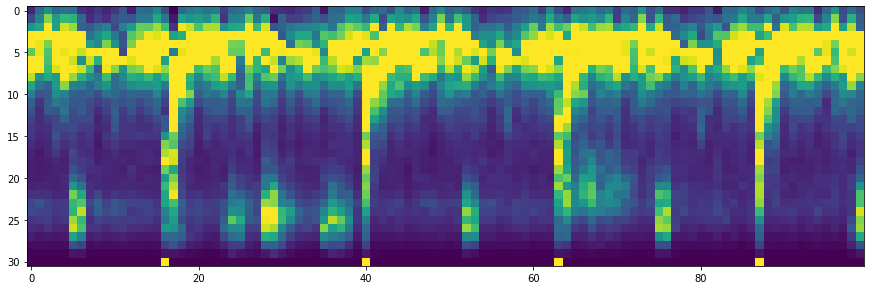

In [208]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
x = 1000
ax.imshow(joined_data[x:x+100].T)

## Generate Training Data



In [220]:
def get_pos_neg_indices(min_len_sample: int, target):
    pos_indices = [i for i in range(len(target)) if i > min_len_sample and target[i]]
    neg_indices = [i for i in range(len(target)) if i > min_len_sample and not target[i]]
    return pos_indices, neg_indices

def get_samples(indices, sample_len, hist, target_val):
    result = []
    for i in indices:
        r = {
            'input': np.flip(np.array(hist[i - sample_len - 1 : i - 1], dtype=np.single), axis=0).flatten(),
            'target': np.array(target_val, dtype=np.single)
        }
        result.append(r)
    return result

def samples_from_dataset(data, hist_len: int, n_weight: int):
    target = data['target']
    hist = data['hist']
    p, n = get_pos_neg_indices(hist_len, target)
    random.shuffle(p)
    random.shuffle(n)
    p_samples = get_samples(p, hist_len, hist, 1)
    n_samples = get_samples(n[:len(p) * n_weight], hist_len, hist, 0)
    return p_samples, n_samples

def load_datasets(data_dir: str, hist_len: int, n_weight: int):
    """Takes a directory in which pickle files of songs are located.  Takes the history length
    that should be used for the input to the network.  takes an n_weight, which gives the number
    of negative samples per positive sample."""
    p_samples = []
    n_samples = []
    for track in os.listdir(data_dir):
        print(f"track: {track}")
        path = os.path.join(data_dir, track)
        data = load_data(path)
        ps, ns = samples_from_dataset(data, hist_len, n_weight)
        p_samples.extend(ps)
        n_samples.extend(ns)
    random.shuffle(p_samples)
    random.shuffle(n_samples)
    # split in tr/va
    print(f"p_samples: {len(p_samples)}")
    tr_p_set_size = round(len(p_samples) * 0.7)
    tr_n_set_size = tr_p_set_size * n_weight
    tr_p_samples = p_samples[:tr_p_set_size]
    tr_n_samples = n_samples[:tr_n_set_size]
    tr_samples = tr_p_samples + tr_n_samples
    # validation
    va_p_samples = p_samples[tr_p_set_size:]
    va_n_samples = n_samples[tr_n_set_size:]
    va_samples = va_p_samples + va_n_samples
    return tr_samples, va_samples

## Neural Network

In [222]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [263]:
class SimpleFF(nn.Module):
    def __init__(self,
                 t: int,
                 d: int):
        super(SimpleFF, self).__init__()
        self.t = t
        self.d = d
        self.ff = nn.Linear(t * d, 1)
        
    def forward(self, inputs):
        out = inputs
        out = self.ff(out)
        out = torch.sigmoid(out)
        return out
    
    def save_to_pickle(self, filename):
        data = {}
        data['weights'] = self.ff.weight.detach().numpy().reshape((self.t, self.d)).tolist()
        data['bias'] = self.ff.bias.detach().numpy()[0]
        with open(filename, 'wb') as f:
            pickle.dump(data, f)

In [259]:
def validate_model(model, data_loader):
    model.eval()
    correct = 0
    for sample in data_loader:
        out = model(sample['input'])
        beat = out.data[0] > 0.5
        correct += beat == (sample['target'] == 1)
    v = float(correct)/len(data_loader)
    return v

def train(model, tr_set, va_set, epochs=10):
    optimizer = torch.optim.Adam(model.parameters())
    tr_loader = DataLoader(tr_set, shuffle=True)
    va_loader = DataLoader(va_set, shuffle=True)
    
    for epoch in tqdm(range(epochs)):
        model.train()
        for sample in tr_loader:
            x = sample['input']
            y = sample['target']
            out = model(x)
            #print(f"out: {out}")
            loss = F.mse_loss(out, y[:,None])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        tr_acc = validate_model(model, tr_loader)
        va_acc = validate_model(model, va_loader)
        print(f"Acc tr: {tr_acc:.02f}; va: {va_acc:.02f}")

In [267]:
input_t = 50
tr_samples, va_samples = load_datasets(DATA_DIR, input_t, 5)

track: 3.pickle
track: 0.pickle
track: 4.pickle
track: 6.pickle
track: 5.pickle
track: 2.pickle
track: 1.pickle
p_samples: 7104


In [268]:
model = SimpleFF(input_t, 30)
train(model, tr_samples, va_samples, epochs=3)

Acc tr: 0.95; va: 0.95
Acc tr: 0.95; va: 0.95
Acc tr: 0.96; va: 0.96



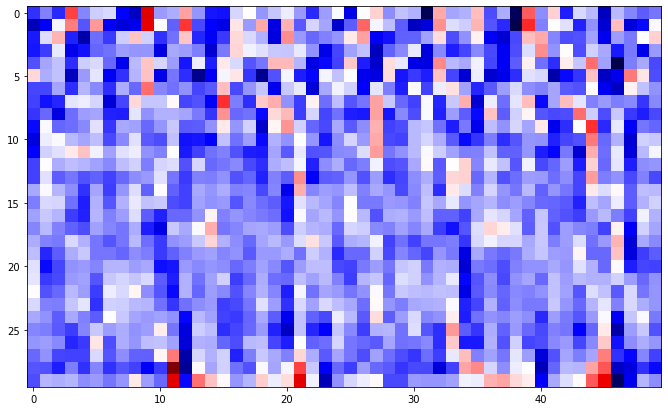

In [269]:
w = model.ff.weight.detach().numpy().reshape((50, 30))
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.imshow(w.T, cmap='seismic')

In [252]:
model.save_to_pickle("model.pickle")

In [249]:
# TODO: normalize values.  Add noise on input.  Try L1 reg. .. batching!
# also I should save the parameters at data generation, carry them through here and 
# save them in the model.pickle to load later